In [1]:
import os

# set pwd to root of repository
repo_root = 'C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/'
#repo_root = '/uufs/chpc.utah.edu/common/home/u0740821/conformal_prediction/vigilant-computing-machine'

os.chdir(repo_root)

In [14]:
# 'vigilant-computing-machine/source/util.py'
import source.util as util

import numpy as np
# from sklearn.neighbors import KNeighborsClassifier

import Orange
# from Orange.distance import Euclidean
import orangecontrib.conformal as cp

# set NumPy seed for Orange3-Conformal reproducibility
np.random.seed(42)

# `BrCaClassifier` without `orange3-conformal`

In [18]:
# import orangecontrib.conformal

import pandas as pd

import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

base = importr('base')
utils = importr('utils')

# set seed for reproducibility
base.set_seed(42)

# TODO rpy2 usings

# Note: R (R_HOME) needs to be in PATH



class BrCaClassifier():
    
    def __init__(self, train_in=None):
        self.bcra = importr('BCRA')
        
        # if R package 'BCRA' is not installed
        if not rpackages.isinstalled('BCRA'):
            # selecting first mirror in list for R packages prevents selection dialog
            utils.chooseCRANmirror(ind=1)
            # install R package 'BCRA'
            utils.install_packages('BCRA')
            
        assert rpackages.isinstalled('BCRA')
        bcra = importr('BCRA')
        self.bcra_version = bcra.__version__ # 2.1.2
        
        if type(train_in) != type(None):
            self.fit(train_in)
            
            
    def __call__(self, train_in=None):
        if type(train_in) != type(None):
            self.fit(train_in)
        
            
    def fit(self, train_in):
        assert (type(train_in) == pd.DataFrame)
        with localconverter(ro.default_converter + pandas2ri.converter):
            self.train = self.coerce_df_dtypes(train_in.copy())
            self.train['absolute_risk'] = self.bcra.absolute_risk(self.train)
            self.median_abs_risk = self.train.absolute_risk.median()

            
    def predict(self, pd_df):
        assert self.median_abs_risk > 0 # has already been fit
        with localconverter(ro.default_converter + pandas2ri.converter):
            return self.bcra.absolute_risk(ro.DataFrame(pd_df)) >= self.median_abs_risk


    def coerce_df_dtypes(self, df_in):
        df_out = pd.DataFrame(df_in).copy()
        df_out = df_out.astype({
            'ID': int,
            'T1': float,
            'T2': float,
            'N_Biop': int,
            'HypPlas': int,
            'AgeMen': int,
            'Age1st': int,
            'N_Rels': int,
            'Race': int
        })
        return df_out

In [218]:
# import util

import pandas as pd

import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

base = importr('base')
utils = importr('utils')

# set seed for reproducibility
base.set_seed(42)

# TODO rpy2 usings

# Note: R (R_HOME) needs to be in PATH


class BrCaClassifier():
    
    def __init__(self, train_in=None):
        self.bcra = importr('BCRA')
        
        # if R package 'BCRA' is not installed
        if not rpackages.isinstalled('BCRA'):
            # selecting first mirror in list for R packages prevents selection dialog
            utils.chooseCRANmirror(ind=1)
            # install R package 'BCRA'
            utils.install_packages('BCRA')
            
        assert rpackages.isinstalled('BCRA')
        bcra = importr('BCRA')
        self.bcra_version = bcra.__version__ # 2.1.2
        
        if type(train_in) != type(None):
            self.fit(train_in)
            
            
    #def __call__(self, instance):
        #return self.predict(instance)
    def __call__(self, train_in=None):
        if type(train_in) != type(None):
            return BrCaClassifier(train_in)
        
            
    def fit(self, train_in):
        if type(train_in) == Orange.data.Table:
            train_in = self.table_to_bcra_df(train_in)
        assert (type(train_in) == pd.DataFrame)
        with localconverter(ro.default_converter + pandas2ri.converter):
            self.train = self.coerce_df_dtypes(train_in.copy())
            self.train['absolute_risk'] = self.bcra.absolute_risk(self.train)
            self.median_abs_risk = self.train.absolute_risk.median()
            self.train['pred'] = self.train['absolute_risk'] >= self.median_abs_risk

            
    def predict(self, pd_df):
        assert self.median_abs_risk > 0 # has already been fit
        if type(pd_df) == Orange.data.RowInstance:
            pd_df = Orange.data.Table.from_list(pd_df.domain, [pd_df])
        if type(pd_df) == Orange.data.Table:
            pd_df = self.table_to_bcra_df(pd_df)
        with localconverter(ro.default_converter + pandas2ri.converter):
#             pd_df = self.coerce_df_dtypes(pd_df)
            self.last_pred_ar = self.bcra.absolute_risk(ro.DataFrame(pd_df))
            return self.last_pred_ar >= self.median_abs_risk


    def coerce_df_dtypes(self, df_in):
        df_out = pd.DataFrame(df_in).copy()
        df_out = df_out.astype({
            'ID': int,
            'T1': float,
            'T2': float,
            'N_Biop': int,
            'HypPlas': int,
            'AgeMen': int,
            'Age1st': int,
            'N_Rels': int,
            'Race': int
        })
        return df_out
    
    
    def table_to_bcra_df(self, tab):
        tab = util.table_to_df(tab, x_only=False)
        if 'ID' not in tab.columns.values:
            tab.index.name = 'ID'
            tab = tab.reset_index()
        return tab

from orangecontrib.conformal.nonconformity import ClassNC
class BrCaNonconformity(ClassNC):


    def __init__(self, classifier):
        """Store the provided classifier as :py:attr:`learner`."""
        assert  isinstance(classifier, BrCaClassifier)
        #self.learner = classifier
        self.clf = classifier
        self.model = None


    def fit(self, data):
        #assert len(data.domain.class_var.values) == 2, \
        #    "BrCaNonconformity only supports binary classification"
        self.clf.fit(data)


    def nonconformity(self, instance):
        with localconverter(ro.default_converter + pandas2ri.converter):
            y = self.clf.predict(instance)[0]
            iar = self.clf.bcra.absolute_risk(ro.DataFrame(instance))[0]
            df = self.clf.train
            ar = df.loc[(df['pred']==y), 'absolute_risk']
            return sum(ar >= iar) / len(ar)


#from orangecontrib.conformal.nonconformity import ClassModelNC
#class BrCaNonconformity(ClassModelNC):


#    def __init__(self, classifier):
#        """Store the provided classifier as :py:attr:`learner`."""
#        assert  isinstance(classifier, BrCaClassifier)
#        self.learner = classifier
#        self.model = None

In [399]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(df, train_size=0.9, test_size=0.1)
# train, calibrate = train_test_split(train, train_size=0.8, test_size=0.2)
nc = BrCaNonconformity(BrCaClassifier())
nc.fit(train)

alpha = []
ys = []
cal = []
for i,r in calibrate.iterrows():
    alpha.append(nc.nonconformity(r))
    ys.append(r.Case_signalYN)
    cal.append(r)

d = pd.DataFrame()
d['alpha'] = alpha
d['y'] = ys
d['calibrate'] =  cal
d.sort_values(by='alpha')

dom = Orange.data.Domain([Orange.data.ContinuousVariable(name='alpha', number_of_decimals=5)],
                         Orange.data.DiscreteVariable(name='y', values=('0','1')))

t = Orange.data.Table.from_numpy(domain=dom,
                                 X=np.atleast_2d(d['alpha'].values.reshape(-1,1)),
                                 Y=d['y'].values)

lr = Orange.classification.LogisticRegressionLearner()
mod = lr(t)

print(mod.coefficients, 'coefficients')
print(mod.intercept, 'intercept')

print(mod.predict(t.X[0].reshape(1,-1)))
print(mod.predict(t.X[1].reshape(1,-1)))
print(mod.predict(t.X[-2].reshape(1,-1)))

print(mod.predict(t.X[-1].reshape(1,-1)))
print(mod(t.X[-1].reshape(1,-1), ret=Orange.base.Model.Probs))

[[1.22686007]] coefficients
[-0.43693494] intercept
(array([0.]), array([[0.57016025, 0.42983975]]))
(array([1.]), array([[0.45704005, 0.54295995]]))
(array([0.]), array([[0.53766689, 0.46233311]]))
(array([1.]), array([[0.34046258, 0.65953742]]))
[[0.34046258 0.65953742]]


In [ ]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(df, train_size=0.9, test_size=0.1)
# train, calibrate = train_test_split(train, train_size=0.8, test_size=0.2)

# class InductiveClassifierBrCa(cp.classification.ConformalClassifier):
class InductiveClassifierBrCa(cp.classification.InductiveClassifier):
    
    def __init__(self, nc_measure, train, calibrate, mondrian=False):
        super().__init__(nc_measure, mondrian=mondrian)
        if train is noot None and calibrate is not None:
            self.fit(train, calibrate)
            
    def fit(self, trian, calibrate): # try overridding to see if can use df and not Table
        self.calibrate = calibrate
        self.

In [399]:
nc = BrCaNonconformity(BrCaClassifier())
nc.fit(train)

alpha = []
ys = []
cal = []
for i,r in calibrate.iterrows():
    alpha.append(nc.nonconformity(r))
    ys.append(r.Case_signalYN)
    cal.append(r)

d = pd.DataFrame()
d['alpha'] = alpha
d['y'] = ys
d['calibrate'] =  cal
# d.sort_values(by='alpha')

dom = Orange.data.Domain([Orange.data.ContinuousVariable(name='alpha', number_of_decimals=5)],
                         Orange.data.DiscreteVariable(name='y', values=('0','1')))

t = Orange.data.Table.from_numpy(domain=dom,
                                 X=np.atleast_2d(d['alpha'].values.reshape(-1,1)),
                                 Y=d['y'].values)

lr = Orange.classification.LogisticRegressionLearner()
mod = lr(t)

print(mod.coefficients, 'coefficients')
print(mod.intercept, 'intercept')

print(mod.predict(t.X[0].reshape(1,-1)))
print(mod.predict(t.X[1].reshape(1,-1)))
print(mod.predict(t.X[-2].reshape(1,-1)))

print(mod.predict(t.X[-1].reshape(1,-1)))
print(mod(t.X[-1].reshape(1,-1), ret=Orange.base.Model.Probs))

[[1.22686007]] coefficients
[-0.43693494] intercept
(array([0.]), array([[0.57016025, 0.42983975]]))
(array([1.]), array([[0.45704005, 0.54295995]]))
(array([0.]), array([[0.53766689, 0.46233311]]))
(array([1.]), array([[0.34046258, 0.65953742]]))
[[0.34046258 0.65953742]]


In [220]:
nc.nonconformity(test.iloc[0,:])

0.28321678321678323

In [227]:
(nc.clf.train.absolute_risk >= nc.clf.last_pred_ar[0]).mean()

0.6440972222222222

In [221]:
nc.clf.last_pred_ar

array([9.11830444])

In [222]:
nc.clf.train

,ID,T1,T2,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN,absolute_risk,pred
1032,1140,51.0,90.0,0,99,13,24,0,3,1,8.515786,False
830,439,53.0,90.0,0,99,12,24,1,1,1,15.660100,True
388,750,52.0,90.0,0,99,13,25,2,2,1,19.953276,True
1189,462,55.0,90.0,0,99,13,23,0,1,1,7.382644,False
167,985,46.0,90.0,0,99,12,24,1,2,0,14.246796,True
...,...,...,...,...,...,...,...,...,...,...,...,...
297,627,44.0,90.0,0,99,13,28,0,1,0,10.711396,True
1139,221,53.0,90.0,0,99,13,26,0,1,0,9.417388,False
845,1084,61.0,90.0,0,99,11,25,0,2,1,6.713970,False
752,572,55.0,90.0,0,99,12,98,0,1,1,9.089913,False


In [214]:
ncs = []
for i,r in train.iterrows():
    ncs.append(nc.nonconformity(r))

In [215]:
ncs = np.array(ncs)
np.sort(ncs)

array([0.00290698, 0.00304878, 0.00581395, 0.00609756, 0.00872093,
       0.01162791, 0.01453488, 0.0152439 , 0.0152439 , 0.0152439 ,
       0.01744186, 0.01829268, 0.02034884, 0.02134146, 0.02616279,
       0.02616279, 0.02906977, 0.03197674, 0.03488372, 0.0377907 ,
       0.04069767, 0.04268293, 0.04268293, 0.04268293, 0.04268293,
       0.04268293, 0.04268293, 0.04268293, 0.04360465, 0.04573171,
       0.04651163, 0.0494186 , 0.05182927, 0.05182927, 0.05232558,
       0.05523256, 0.05792683, 0.05792683, 0.05813953, 0.06104651,
       0.06395349, 0.06402439, 0.06402439, 0.06686047, 0.06707317,
       0.07267442, 0.07267442, 0.0755814 , 0.07848837, 0.08231707,
       0.08231707, 0.08231707, 0.08231707, 0.08231707, 0.08430233,
       0.08430233, 0.08536585, 0.0872093 , 0.09011628, 0.09146341,
       0.09146341, 0.09302326, 0.0945122 , 0.09593023, 0.09883721,
       0.10060976, 0.10060976, 0.10365854, 0.10465116, 0.10465116,
       0.10670732, 0.10755814, 0.11046512, 0.11337209, 0.11627

<AxesSubplot:>

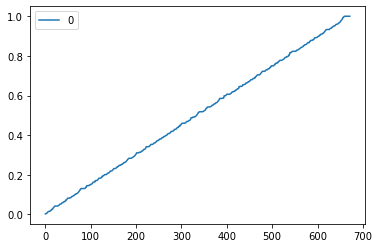

In [216]:
pd.DataFrame(np.sort(ncs)).plot()

In [ ]:
class ConformalPredictor:
    """Base class for conformal predictors."""

    def __call__(self, example, eps):
        """Extending classes should implement this method to return predicted values
        for a given example and significance level."""
        raise NotImplementedError

    def predict(self, example, eps):
        """Extending classes should implement this method to return a prediction object.
        for a given example and significance level."""
        raise NotImplementedErrors

class ConformalClassifier(ConformalPredictor):
    """Base class for conformal classifiers."""

    def __init__(self, nc_measure, mondrian=False):
        """Verify that the nonconformity measure can be used for classification."""
        assert isinstance(nc_measure, ClassNC), "Inappropriate nonconformity measure for classification"
        self.nc_measure = nc_measure
        self.mondrian = mondrian

    def __str__(self):
        return "{} ({})".format(self.__class__.__name__, self.nc_measure)

    def p_values(self, example):
        """Extending classes should implement this method to return a list of pairs (p-value, class)
        for a given example.

        Conformal classifier assigns an assumed class value to the given example and computes its nonconformity.
        P-value is the ratio of more nonconformal (stranger) instances that the given example.
        """
        raise NotImplementedError

    def predict(self, example, eps=None):
        """Compute a classification prediction object from p-values for a given example and significance level.

        Args:
            example (Instance): Orange row instance.
            eps (float): Default significance level (error rate).

        Returns:
            PredictionClass: Classification prediction object.
        """
        ps = self.p_values(example)
        return PredictionClass(ps, eps)

    def __call__(self, example, eps):
        """Compute predicted classes for a given example and significance level.

        Args:
            example (Instance): Orange row instance.
            eps (float): Significance level (error rate).

        Returns:
            List of predicted classes.
        """
        pred = self.predict(example)
        return pred.classes(eps)

class InductiveClassifier(ConformalClassifier):
    """Inductive classification.

    Attributes:
        alpha: Nonconformity scores of the calibration instances. Computed by the :py:func:`fit` method.

    Examples:
        >>> train, test = next(LOOSampler(Table('iris')))
        >>> train, calibrate = next(RandomSampler(train, 2, 1))
        >>> icp = InductiveClassifier(InverseProbability(LogisticRegressionLearner()), train, calibrate)
        >>> print(icp(test[0], 0.1))
    """

    def __init__(self, nc_measure, train=None, calibrate=None, mondrian=False):
        """Initialize inductive classifier with a nonconformity measure, training set and calibration set.
        If present, fit the conformal classifier to the training set and compute the nonconformity scores of
        calibration set.

        Args:
            nc_measure (ClassNC): Classification nonconformity measure.
            train (Optional[Table]): Table of examples used as a training set.
            calibrate (Optional[Table]): Table of examples used as a calibration set.
            mondrian (bool): Use a mondrian setting for computing p-values.
        """
        super().__init__(nc_measure, mondrian=mondrian)
        if train is not None and calibrate is not None:
            self.fit(train, calibrate)

    def fit(self, train, calibrate):
        """Fit the conformal classifier to the training set, compute and store nonconformity scores (:py:attr:`alpha`)
        on the calibration set and store the domain.

        Args:
            train (Optional[Table]): Table of examples used as a training set.
            calibrate (Optional[Table]): Table of examples used as a calibration set.
        """
        self.domain = train.domain
        self.calibrate = calibrate
        self.nc_measure.fit(train)
        self.alpha = np.array([self.nc_measure.nonconformity(inst) for inst in calibrate])

    def p_values(self, example):
        """Compute p-values for every possible class.

        Inductive classifier assigns an assumed class value to the given example and compares its nonconformity
        against all other instances in the calibration set.

        Args:
            example (Instance): Orange row instance.

        Returns:
            List of pairs (p-value, class)
        """
        classes = []
        ps = []
        temp = example.get_class()
        for yi, y in enumerate(self.domain.class_var.values):
            example.set_class(yi)
            alpha_n = self.nc_measure.nonconformity(example)
            if self.mondrian:
                alpha = np.array([a for a, cal in zip(self.alpha, self.calibrate) if cal.get_class() == y])
            else:
                alpha = self.alpha
            p_y = (sum(alpha >= alpha_n)+1) / (len(alpha)+1)
            ps.append((p_y, y))
        example.set_class(temp)
        return ps

In [146]:
# import Orange
# import orangecontrib.conformal as cp

# import os
# os.chdir('C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/source')
# tab_sig = Orange.data.Table('../ML_BCP/data/synthetic/signal.csv')
# tab = Orange.data.Table('../data/signal_with_header_for_orange_include_T2.csv')
# train, test = next(cp.evaluation.RandomSampler(tab, 2, 1))
# train, calibrate = next(cp.evaluation.RandomSampler(train, 2, 1))
# ic = cp.classification.InductiveClassifier(
#     BrCaNonconformity(
#         BrCaClassifier()))
# ic.fit(train, calibrate)
# pred = ic.predict(test)

# ic = cp.classification.InductiveClassifier(
#     cp.nonconformity.InverseProbability(
#         Orange.classification.LogisticRegressionLearner()), 
#     train, 
#     calibrate)
# pred = ic.predict(test)

In [147]:
# # from sklearn.model_selection import train_test_split
# # df = pd.read_csv('./ML_BCP/data/synthetic/signal.csv')
# ic = cp.classification.InductiveClassifier(cp.nonconformity.InverseProbability(BrCaClassifier(df)))
# train, test = train_test_split(df, train_size=0.8, test_size=0.2)
# train, calibrate = train_test_split(train, train_size=0.7, test_size=0.3)


In [30]:
os.chdir('C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/source')
tab_sig = Orange.data.Table('../ML_BCP/data/synthetic/signal.csv')
tab = Orange.data.Table('../data/signal_with_header_for_orange.csv')
test = tab[-1]
train, calibrate = next(cp.evaluation.RandomSampler(tab[:-1], 2, 1))
ic = cp.classification.InductiveClassifier(
    cp.nonconformity.InverseProbability(
        Orange.classification.LogisticRegressionLearner()), 
    train, 
    calibrate)
pred = ic.predict(test)

C:\Users\Bob\anaconda3\envs\orange38R\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
pred.p

[(0.6583541147132169, '0'), (0.0024937655860349127, '1')]

In [35]:
ic.alpha[:5]

array([0.13053811, 0.07879405, 0.17317919, 0.00492505, 0.66099504])

In [37]:
ic.calibrate[:3]

[[49, 0, 99, 13, 22, ... | 0],
 [48, 0, 99, 12, 24, ... | 0],
 [55, 0, 99, 12, 23, ... | 1]
]

In [40]:
ic.p_values(test)

[(0.6583541147132169, '0'), (0.0024937655860349127, '1')]

In [42]:
ic.nc_measure.nonconformity(test)

0.03745946548598811

In [68]:
tab[0].domain

[T1, N_Biop, HypPlas, AgeMen, Age1st, N_Rels, Race | Case_signalYN]

In [71]:
Orange.data.Table.from_list?

In [21]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('./ML_BCP/data/synthetic/signal.csv')
train, test = train_test_split(df, train_size=0.8, test_size=0.2)

In [6]:
clf = ClassifierBrCa(train)

In [7]:
clf.median_abs_risk

10.188236827700118

In [8]:
clf = ClassifierBrCa(df)

In [9]:
clf.median_abs_risk

10.188236827700118

In [10]:
clf = ClassifierBrCa(test)

In [11]:
clf.median_abs_risk

10.092176772060679

In [12]:
pred = clf.predict(test)

In [13]:
clf.predict(test.iloc[-1,:])

array([ True])

In [36]:
import sklearn.metrics

In [37]:
sum(df.Case_signalYN == clf.predict(df)) / len(df)

0.4575

In [16]:
sklearn.metrics.accuracy_score(y_true=test.Case_signalYN, y_pred=pred)

0.4666666666666667

In [4]:
tab_signal = util.read_csv_to_table('./data/signal_with_header_for_orange_include_T2.csv', 
                                    normalize=False)
df_signal = util.table_to_df(tab_signal)
train, test, calibrate = util.train_test_calibrate_split(tab_signal, 
                                                         train_test_ratio=(9,1), 
                                                         train_calibrate_ratio=(3, 1))
train = util.table_to_df(train)
test = util.table_to_df(test)
calibrate = util.table_to_df(calibrate)

In [402]:
ran = pd.read_csv('../ML_BCP/data/synthetic/random.csv')
sig = pd.read_csv('../ML_BCP/data/synthetic/signal.csv')
mis = pd.read_csv('../ML_BCP/data/synthetic/missing.csv')
imp = pd.read_csv('../ML_BCP/data/synthetic/imputed.csv')

rclf = BrCaClassifier(ran)
sclf = BrCaClassifier(sig)
mclf = BrCaClassifier(mis)
iclf = BrCaClassifier(imp)

print('Random (absolute risk)')
print(rclf.train.absolute_risk.mean(), '(mean)')
print(rclf.median_abs_risk, '(median)')
print(rclf.train.absolute_risk.mean() - rclf.train.absolute_risk.median(), '(mean - median)')
print(rclf.train.Case_Random.sum()/len(rclf.train), '(proportion cancer)')
print()
print('Signal (absolute risk)')
print(sclf.train.absolute_risk.mean(), '(mean)')
print(sclf.median_abs_risk, '(median)')
print(sclf.train.absolute_risk.mean() - sclf.train.absolute_risk.median(), '(mean - median)')
print(sclf.train.Case_signalYN.sum()/len(sclf.train), '(proportion cancer)')
print()
print('Random - Signal (proportion cancer)')
print((rclf.train.Case_Random.sum()/len(rclf.train)) - 
      (sclf.train.Case_signalYN.sum()/len(sclf.train)))
print()
print('Random - Signal (published accuracy)')
print(0.5333 - 0.5261)
print()
print('Missing (absolute risk)')
print(mclf.train.absolute_risk.mean(), '(mean)')
print(mclf.median_abs_risk, '(median)')
print(mclf.train.absolute_risk.mean() - mclf.train.absolute_risk.median(), '(mean - median)')
print(mclf.train.Case_signalYN.sum()/len(mclf.train), '(proportion cancer)')
print()
print('Imputed (absolute risk)')
print(iclf.train.absolute_risk.mean(), '(mean)')
print(iclf.median_abs_risk, '(median)')
print(iclf.train.absolute_risk.mean() - iclf.train.absolute_risk.median(), '(mean - median)')
print(iclf.train.Case_signalYN.sum()/len(iclf.train), '(proportion cancer)')
print()

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2)
rclf.train.sort_values(by='absolute_risk').reset_index(drop=True).plot(y=['absolute_risk'], use_index=True, title='Random', ax=axs[0,0])
axs[0,0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sclf.train.sort_values(by='absolute_risk').reset_index(drop=True).plot(y=['absolute_risk'], use_index=True, title='Signal', ax=axs[0,1])
axs[0,1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
mclf.train.sort_values(by='absolute_risk').reset_index(drop=True).plot(y=['absolute_risk'], use_index=True, title='Missing', ax=axs[1,0])
axs[1,0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
iclf.train.sort_values(by='absolute_risk').reset_index(drop=True).plot(y=['absolute_risk'], use_index=True, title='Imputed', ax=axs[1,1])
axs[1,1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[0,0].set_ylabel('absolute risk')
axs[1,0].set_ylabel('absolute risk')

In [93]:
# import orangecontrib.conformal

import pandas as pd

import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

base = importr('base')
utils = importr('utils')

# TODO rpy2 usings

# Note: R (R_HOME) needs to be in PATH



class ClassifierBrCa():
    
    def __init__(self, pd_df_train_Case_signalYN=None):
        self.bcra = importr('BCRA')
        
        # if R package 'BCRA' is not installed
        if not rpackages.isinstalled('BCRA'):
            # selecting first mirror in list for R packages
            # prevents selection dialog
            utils.chooseCRANmirror(ind=1)

            # install R package 'BCRA'
            utils.install_packages('BCRA')
        assert rpackages.isinstalled('BCRA')
        bcra = importr('BCRA')
        self.bcra_version = bcra.__version__ # 2.1.2
        
        if type(pd_df_train_Case_signalYN) == pd.DataFrame:
            self.fit(pd_df_train_Case_signalYN)
        
            
    def fit(self, pd_df_train_Case_signalYN):
        self.train = pd.DataFrame(pd_df_train_Case_signalYN).copy()
        self.train = self.train.astype({
            'T1': float,
            'T2': float,
            'N_Biop': int,
            'HypPlas': int,
            'AgeMen': int,
            'Age1st': int,
            'N_Rels': int,
            'Race': int
        })        
        with localconverter(ro.default_converter + pandas2ri.converter):
            self.r_df_train_Case_signalYN = ro.conversion.py2rpy(pd_df_train_Case_signalYN)
#             ar = self.bcra.absolute_risk(pd_df_train_Case_signalYN)
            ar = self.bcra.absolute_risk(self.train)
            self.train['absolute_risk'] = ar
            self.median_abs_risk = np.median(ar)
            print(self.median_abs_risk)
            
            
    def predict(self, pd_df):
        assert self.median_abs_risk > 0 # has been fit
        
        with localconverter(ro.default_converter + pandas2ri.converter):
#             ar = self.bcra.absolute_risk(ro.DataFrame(pd_df))
            return self.bcra.absolute_risk(ro.DataFrame(pd_df)) >= self.median_abs_risk
#             r_df = ro.conversion.py2rpy(pd_df)
#             r_df = base.as_data_frame(r_df)
#             ar = self.bcra.absolute_risk(r_df)
#             print(ar)
#             print(self.median_abs_risk)
#             return ar >= self.median_abs_risk
        #
#         with localconverter(ro.default_converter + pandas2ri.converter):
#             return self.bcra.absolute_risk(
#                     pd.DataFrame(
#                         pd_df)) >= self.median_abs_risk



In [80]:
train = df.iloc[:-1,]
test = df.iloc[-1,]

In [81]:
pd.DataFrame(test)

,1199
ID,74.0
T1,47.0
T2,90.0
N_Biop,0.0
HypPlas,2.0
AgeMen,12.0
Age1st,23.0
N_Rels,1.0
Race,1.0


In [85]:
clf = ClassifierBrCa(train)
clf.predict(test)

AttributeError: 'DataFrame' object has no attribute 'domain'

In [83]:
clf = ClassifierBrCa(train)
preds=clf.predict(train)
print(len(preds))
sum(preds)

nan


C:\Users\Bob\anaconda3\envs\orange38R\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


AssertionError: 

In [36]:
clf = ClassifierBrCa(train)
clf.predict(train.iloc[0:2, :])

10.188236827700118


array([False, False])

In [8]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

base = importr('base')
utils = importr('utils')

from functools import partial
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class='docutils')
html.init_printing()

C:\Users\Bob\anaconda3\envs\orange38R\lib\site-packages\rpy2-3.5.3-py3.8.egg\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


Read in data as R DataFrame

In [9]:
dataf = utils.read_csv('./ML_BCP/data/synthetic/signal.csv', )
# dataf.names
dataf

,,ID,T1,T2,N_Biop,...,Race,Case_signalYN
0,1,561,53,90,1,...,3,1
1,2,321,53,90,0,...,2,0
2,3,1177,53,90,1,...,1,1
3,4,1098,51,90,0,...,3,1
4,5,1170,51,90,1,...,1,0
5,6,634,58,90,3,...,1,1
6,7,49,56,90,0,...,3,1
7,8,1152,48,90,0,...,3,0
...,...,...,...,...,...,...,...,...
1198,1199,538,54,90,0,...,3,1


Read in data as Python pandas DataFrame

In [10]:
df = util.table_to_df(util.read_csv_to_table('./data/signal_with_header_for_orange.csv', normalize=False))
df

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race
0,53.0,1.0,0.0,13.0,25.0,0.0,2.0
1,53.0,0.0,2.0,11.0,22.0,0.0,1.0
2,53.0,1.0,0.0,12.0,28.0,0.0,0.0
3,51.0,0.0,2.0,13.0,98.0,3.0,2.0
4,51.0,1.0,1.0,13.0,24.0,0.0,0.0
...,...,...,...,...,...,...,...
1195,55.0,0.0,2.0,12.0,26.0,0.0,0.0
1196,48.0,3.0,1.0,13.0,21.0,0.0,3.0
1197,57.0,3.0,0.0,14.0,26.0,0.0,0.0
1198,54.0,0.0,2.0,11.0,25.0,0.0,2.0


Convert pandas DataFrame to R DataFrame

In [11]:
with localconverter(ro.default_converter + pandas2ri.converter):
    r_from_pd_df = ro.conversion.py2rpy(df)

r_from_pd_df

,,T1,N_Biop,HypPlas,AgeMen,...,N_Rels,Race
0,0,53.0,1.0,0.0,13.0,...,0.0,2.0
1,1,53.0,0.0,2.0,11.0,...,0.0,1.0
2,2,53.0,1.0,0.0,12.0,...,0.0,0.0
3,3,51.0,0.0,2.0,13.0,...,3.0,2.0
4,4,51.0,1.0,1.0,13.0,...,0.0,0.0
5,5,58.0,3.0,0.0,11.0,...,0.0,0.0
6,6,56.0,0.0,2.0,11.0,...,0.0,2.0
7,7,48.0,0.0,2.0,13.0,...,0.0,2.0
...,...,...,...,...,...,...,...,...
1198,1198,54.0,0.0,2.0,11.0,...,0.0,2.0


Convert R DataFrame to pandas DataFrame

In [12]:
with localconverter(ro.default_converter + pandas2ri.converter):
    pd_from_r_df = ro.conversion.rpy2py(dataf)

pd_from_r_df

,ID,T1,T2,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
1,561,53,90,1,0,13,25,0,3,1
2,321,53,90,0,99,11,22,0,2,0
3,1177,53,90,1,0,12,28,0,1,1
4,1098,51,90,0,99,13,98,3,3,1
5,1170,51,90,1,1,13,24,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1196,875,55,90,0,99,12,26,0,1,1
1197,890,48,90,3,1,13,21,0,4,0
1198,383,57,90,3,0,14,26,0,1,1
1199,538,54,90,0,99,11,25,0,3,1


In [13]:
dataf.colnames

ID,T1,T2,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN


In [14]:
for i in dataf.iter_row():
    print(i)
    break

   ID T1 T2 N_Biop HypPlas AgeMen Age1st N_Rels Race Case_signalYN
1 561 53 90      1       0     13     25      0    3             1



In [31]:
bcra_ex_data = utils.data(bcra.exampledata)
# bcra_ex_data = utils.data('BCRA.
# bcra_ex_data = utils.data('BCRA::exampledata')

bcra_ex_data

AttributeError: module 'BCRA' has no attribute 'exampledata'

In [5]:
import rpy2
import rpy2.robjects.packages as rpackages # importing rpy2's package module
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.vectors import IntVector
import rpy2.rlike.container as rlc

# importing R's utility package
utils = importr('utils')

# importing R's base package
base = importr('base')

# set seed for reproducibility
base.set_seed(42)

print(rpy2.__version__) # 2.9.4
rpy2.robjects.r['pi'] # 3.141593

3.5.3


3.141593


In [6]:
# selecting first mirror in list for R packages
utils.chooseCRANmirror(ind=1) # else, dialog will prompt for selection
packnames = ('ggplot2', 'BCRA')
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
names_to_install

[]

In [7]:
# if len(names_to_install) > 0:
#     utils.install_packages(StrVector(names_to_install))

#TODO: ggplot2 error per dependency 'scales' wants 'rlang' >= 1.0.0, but 0.4.11 is present

rpackages.isinstalled('BCRA') # True

True

In [8]:
bcra = importr('BCRA')
bcra.__version__ # 2.1.2

'2.1.2'

In [11]:
tab_signal = util.read_csv_to_table('./data/signal_with_header_for_orange.csv', normalize=False)
tab_signal.domain.attributes

(ContinuousVariable(name='T1', number_of_decimals=0),
 DiscreteVariable(name='N_Biop', values=('0', '1', '2', '3', '4', '5', '6')),
 DiscreteVariable(name='HypPlas', values=('0', '1', '99')),
 ContinuousVariable(name='AgeMen', number_of_decimals=0),
 ContinuousVariable(name='Age1st', number_of_decimals=0),
 DiscreteVariable(name='N_Rels', values=('0', '1', '2', '3', '4', '5', '6')),
 DiscreteVariable(name='Race', values=('1', '2', '3', '4', '5', '6', '7')))

In [12]:
tab = util.table_to_df(tab_signal)
tab

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race
0,53.0,1.0,0.0,13.0,25.0,0.0,2.0
1,53.0,0.0,2.0,11.0,22.0,0.0,1.0
2,53.0,1.0,0.0,12.0,28.0,0.0,0.0
3,51.0,0.0,2.0,13.0,98.0,3.0,2.0
4,51.0,1.0,1.0,13.0,24.0,0.0,0.0
...,...,...,...,...,...,...,...
1195,55.0,0.0,2.0,12.0,26.0,0.0,0.0
1196,48.0,3.0,1.0,13.0,21.0,0.0,3.0
1197,57.0,3.0,0.0,14.0,26.0,0.0,0.0
1198,54.0,0.0,2.0,11.0,25.0,0.0,2.0


In [78]:
dct = []

for col_name, col_vals in tab.T.iterrows():
    dct.append((col_name, IntVector(col_vals)))

od = rlc.OrdDict(dct)
od

o{'T1':    [1] 53 53 53 51 51 58 56 48 58 52 48 52 51 52 47 47 58 56 47 47 60 61 48 45

  [25] 65 53 52 52 59 51 59 50 54 46 52 58 51 58 65 56 50 52 49 62 37 52 52 53

  [49] 44 53 52 58 54 57 47 51 52 53 48 59 48 43 54 55 56 47 50 45 56 53 56 55

  [73] 48 52 42 54 56 47 41 44 46 58 52 45 54 41 50 57 50 58 60 46 46 47 54 56

  [97] 58 58 57 56 52 47 48 54 60 60 42 47 59 46 43 54 60 61 54 55 54 51 35 55

 [121] 50 57 48 43 58 52 69 56 57 55 48 50 57 57 54 47 60 45 49 63 54 56 53 47

 [145] 49 52 37 47 55 50 50 56 49 55 44 45 43 52 50 59 51 58 61 49 53 47 55 46

 [169] 46 53 52 53 52 49 51 60 51 45 47 46 47 45 38 55 55 50 48 47 53 53 54 52

 [193] 55 54 54 54 60 46 59 50 51 52 49 39 50 52 43 54 49 59 53 48 52 53 56 51

 [217] 41 45 47 54 50 48 47 52 47 50 47 45 56 45 52 49 46 53 53 58 53 51 65 48

 [241] 46 49 51 55 54 51 47 57 56 48 55 54 57 52 46 56 48 54 60 44 59 58 49 50

 [265] 48 49 54 47 51 51 51 52 59 49 48 55 53 53 54 44 57 54 56 49 42 49 47 63

 [289] 49 50 57 55 55 65 52 61 5

In [79]:
rdf = rpy2.robjects.DataFrame(od)
rdf

T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race
53,1,0,13,25,0,2
53,0,2,11,22,0,1
53,1,0,12,28,0,0
51,0,2,13,98,3,2
...,...,...,...,...,...,...
48,3,1,13,21,0,3
57,3,0,14,26,0,0
54,0,2,11,25,0,2
47,0,2,12,23,1,1


In [102]:
# base.summary(rdf)
print(rdf.names)
print(utils.str(rdf)) # str() output goes to console

# 'data.frame':   1200 obs. of  7 variables:
#  $ T1     : int  53 53 53 51 51 58 56 48 58 52 ...
#  $ N_Biop : int  1 0 1 0 1 3 0 0 0 0 ...
#  $ HypPlas: int  0 2 0 2 1 0 2 2 2 2 ...
#  $ AgeMen : int  13 11 12 13 13 11 11 13 14 13 ...
#  $ Age1st : int  25 22 28 98 24 24 24 98 25 23 ...
#  $ N_Rels : int  0 0 0 3 0 0 0 0 0 1 ...
#  $ Race   : int  2 1 0 2 0 0 2 2 3 3 ...

[1] "T1"      "N_Biop"  "HypPlas" "AgeMen"  "Age1st"  "N_Rels"  "Race"   

NULL


In [93]:
# Note: R uses '.' (dot) to separate words in symbols, 
#       similar to '_' in Python. Because, in Python,
#       dot means "attribute in a namespace", importr
#       may sometimes translate '.' to '_'

# bcra.risk.summary
bcra.risk_summary?

In [96]:
bcra.risk_summary(rdf)

RRuntimeError: Error in ceiling(obs$T2) : non-numeric argument to mathematical function
